In [42]:
import os
import csv
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [43]:
from scipy import interpolate

In [44]:
from prettytable import PrettyTable

In [45]:
# Changing Directory
os.chdir("D:\dataset")

## Train set

In [46]:
# Reading Data
df = pd.read_csv('train.csv')
df.head()

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,windows_ie,180.107.112.*,80,85,...,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063"
1,0,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,windows_chrome,125.120.199.*,94,95,...,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,"10063,10111"
2,0,5,9,2912cb5947e1fad450e2473c2f61ef75,1,u_VhkyORMrD8TP3GL,windows_ie,120.196.64.*,216,217,...,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,76,bebefa5efe83beee17a3d245e7c5085b,1458,10063
3,0,2,20,d7b7d61d1e50e1d27d210928d28a9b61,1,u_VhkyLRqVL2a4eWL,windows_ie,219.131.122.*,216,221,...,90,0,0,162,7184c9560e68e977187e67e45a4f3198,238,182,0f951a030abdaedd733ee8d114ce2944,3427,"10077,10111"
4,0,6,9,657d317dc4045bb79c2652abbea07530,1,u_Vh1zOJuQOtTCBgL,windows_chrome,123.190.78.*,40,48,...,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,34,a3becb967c015e9acb5e72f22b100ef8,3476,"10031,13042,10006,10057,13866,10063,14273,1005..."


## Selecting Wanted Features

In [47]:
# Define our features
features = ["click", "weekday", "hour", "city", "slotwidth", 'slotheight', 'useragent', 'payprice', 'bidprice', 'slotformat', 'advertiser']
df = df[features]
df = df.dropna()

In [48]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [49]:
df.head()

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,1,14,85,windows_ie,54,300,0,1458,28080
1,0,2,20,95,windows_chrome,42,249,0,3476,62500
2,0,5,9,217,windows_ie,76,300,1,1458,94080
3,0,2,20,221,windows_ie,182,238,0,3427,65520
4,0,6,9,48,windows_chrome,34,238,1,3476,85500


## Labeling and Categorising Data

Categorising:
- Hour: 
    - 0:00~07:59 : 1
    - 08:00~15:59: 2
    - 16:00~23:59: 3
- Size:
    - 0~40000     : 1
    - 40000~80000 : 2
    - 80000~120000: 3

In [50]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
df.head()  

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,1,2,85,windows_ie,54,300,0,1458,1
1,0,2,3,95,windows_chrome,42,249,0,3476,2
2,0,5,2,217,windows_ie,76,300,1,1458,3
3,0,2,3,221,windows_ie,182,238,0,3427,2
4,0,6,2,48,windows_chrome,34,238,1,3476,3


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697738 entries, 0 to 2697737
Data columns (total 10 columns):
click         int64
weekday       int64
hour          category
city          int64
useragent     object
payprice      int64
bidprice      int64
slotformat    object
advertiser    int64
slotsize      category
dtypes: category(2), int64(6), object(2)
memory usage: 190.4+ MB


In [52]:
df = df.dropna()
df.isnull().any().any()

False

In [53]:
from sklearn import preprocessing

# Set the random seed
np.random.seed(12)

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

### Dummy Coding

In [54]:
df["click"] = label_encoder.fit_transform(df["click"])
df["weekday"] = label_encoder.fit_transform(df["weekday"])
df["city"] = label_encoder.fit_transform(df["city"])

df["hour"] = label_encoder.fit_transform(df["hour"])
df["slotsize"] = label_encoder.fit_transform(df["slotsize"])
# df["slotformat"] = label_encoder.fit_transform(df["slotformat"])
# df["advertiser"] = label_encoder.fit_transform(df["advertiser"])

In [55]:
df_slotformat_dummy = pd.get_dummies(df.slotformat)
df = pd.concat([df, df_slotformat_dummy], axis = 1)
df_advertiser_dummy = pd.get_dummies(df.advertiser)
df = pd.concat([df, df_advertiser_dummy], axis = 1)
df

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,...,Na,1458,2259,2261,2821,2997,3358,3386,3427,3476
0,0,1,1,84,windows_ie,54,300,0,1458,0,...,0,1,0,0,0,0,0,0,0,0
1,0,2,2,94,windows_chrome,42,249,0,3476,1,...,0,0,0,0,0,0,0,0,0,1
2,0,5,1,211,windows_ie,76,300,1,1458,2,...,0,1,0,0,0,0,0,0,0,0
3,0,2,2,215,windows_ie,182,238,0,3427,1,...,0,0,0,0,0,0,0,0,1,0
4,0,6,1,48,windows_chrome,34,238,1,3476,2,...,0,0,0,0,0,0,0,0,0,1
5,0,3,2,6,windows_ie,99,227,1,3358,1,...,0,0,0,0,0,0,1,0,0,0
6,0,5,2,211,windows_chrome,61,277,Na,2259,1,...,1,0,1,0,0,0,0,0,0,0
7,0,0,2,214,windows_chrome,39,294,Na,2821,2,...,1,0,0,0,1,0,0,0,0,0
8,0,4,2,207,windows_ie,111,300,0,3386,2,...,0,0,0,0,0,0,0,1,0,0
9,0,0,2,56,windows_ie,30,300,0,1458,2,...,0,1,0,0,0,0,0,0,0,0


In [56]:
df.columns

Index([     'click',    'weekday',       'hour',       'city',  'useragent',
         'payprice',   'bidprice', 'slotformat', 'advertiser',   'slotsize',
                '0',          '1',          '5',         'Na',         1458,
               2259,         2261,         2821,         2997,         3358,
               3386,         3427,         3476],
      dtype='object')

In [57]:
df.head()

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,...,Na,1458,2259,2261,2821,2997,3358,3386,3427,3476
0,0,1,1,84,windows_ie,54,300,0,1458,0,...,0,1,0,0,0,0,0,0,0,0
1,0,2,2,94,windows_chrome,42,249,0,3476,1,...,0,0,0,0,0,0,0,0,0,1
2,0,5,1,211,windows_ie,76,300,1,1458,2,...,0,1,0,0,0,0,0,0,0,0
3,0,2,2,215,windows_ie,182,238,0,3427,1,...,0,0,0,0,0,0,0,0,1,0
4,0,6,1,48,windows_chrome,34,238,1,3476,2,...,0,0,0,0,0,0,0,0,0,1


In [58]:
df.useragent.value_counts()

windows_ie          1619590
windows_chrome       885179
android_safari        67728
mac_safari            41409
windows_firefox       24765
windows_theworld      15305
windows_other         12461
mac_other              8700
windows_maxthon        8075
windows_opera          2434
mac_chrome             2119
android_other          1956
other_other            1788
windows_safari         1727
linux_chrome           1060
mac_firefox             844
android_chrome          510
android_opera           504
ios_safari              433
linux_firefox           413
linux_safari            133
other_opera             126
linux_other              64
other_safari             63
android_maxthon          35
mac_maxthon              35
ios_other                31
other_ie                 28
linux_opera              20
linux_ie                 19
mac_opera                18
android_firefox          18
android_sogou            15
mac_sogou                14
other_chrome             13
android_ie          

In [59]:
from collections import Counter

In [60]:
len(df.copy().useragent.tolist())

2697646

In [61]:
def useragent_processing(df):
    df_copy = df.copy()
    
    current_attributes = df_copy.useragent.tolist()
    useragent_processing_platform = [0] * len(current_attributes)
        
    for i in range(len(current_attributes)):
        if (current_attributes[i] == 'windows_ie' or\
            current_attributes[i] == 'windows_chrome' or\
            current_attributes[i] == 'windows_firefox' or\
            current_attributes[i] == 'windows_theworld' or\
            current_attributes[i] == 'windows_other' or\
            current_attributes[i] == 'windows_maxthon' or\
            current_attributes[i] == 'windows_opera' or\
            current_attributes[i] == 'windows_safari' or\
            current_attributes[i] == 'windows_sogou'):
            useragent_processing_platform[i] = 0 # windows
            
        elif (current_attributes[i] == 'android_safari' or\
              current_attributes[i] == 'android_other' or\
              current_attributes[i] == 'android_chrome' or\
              current_attributes[i] == 'android_opera' or\
              current_attributes[i] == 'android_maxthon' or\
              current_attributes[i] == 'android_firefox' or\
              current_attributes[i] == 'android_sogou' or\
              current_attributes[i] == 'android_ie'):
            useragent_processing_platform[i] = 1 # android
            
        elif (current_attributes[i] == 'mac_safari' or\
              current_attributes[i] == 'mac_other' or\
              current_attributes[i] == 'mac_chrome' or\
              current_attributes[i] == 'mac_firefox' or\
              current_attributes[i] == 'mac_maxthon' or\
              current_attributes[i] == 'mac_opera' or\
              current_attributes[i] == 'mac_sogou' or\
              current_attributes[i] == 'mac_ie'):
            useragent_processing_platform[i] = 2 # mac
            
        elif (current_attributes[i] == 'linux_chrome' or\
              current_attributes[i] == 'linux_firefox' or\
              current_attributes[i] == 'linux_safari' or\
              current_attributes[i] == 'linux_other' or\
              current_attributes[i] == 'linux_opera' or\
              current_attributes[i] == 'linux_ie'):
            useragent_processing_platform[i] = 3 # linux
            
        elif (current_attributes[i] == 'ios_safari' or\
              current_attributes[i] == 'ios_other'):
            useragent_processing_platform[i] = 4 # ios
            
        elif (current_attributes[i] == 'other_other' or\
              current_attributes[i] == 'other_opera' or\
              current_attributes[i] == 'other_safari' or\
              current_attributes[i] == 'other_ie' or\
              current_attributes[i] == 'other_chrome' or\
              current_attributes[i] == 'other_firefox'):
            useragent_processing_platform[i] = 5 # other
            
        else:
            useragent_processing_platform[i] = 6 # for sanity check
        
    return useragent_processing_platform

In [62]:
useragent_processing_platform = useragent_processing(df)

In [63]:
Counter(useragent_processing_platform)

Counter({0: 2569540, 1: 70774, 2: 53140, 3: 1709, 4: 464, 5: 2019})

In [64]:
df_index = df.index.get_values()

In [65]:
def dummy_coding(df):
    df_copy = df.copy()
    
    windows_true = [0] * len(useragent_processing_platform)
    android_true = [0] * len(useragent_processing_platform)
    mac_true = [0] * len(useragent_processing_platform)
    linux_true = [0] * len(useragent_processing_platform)
    ios_true = [0] * len(useragent_processing_platform)
    other_true = [0] * len(useragent_processing_platform)
    
    for i in range(len(useragent_processing_platform)):
        if useragent_processing_platform[i] == 0:
            windows_true[i] = 1
        elif useragent_processing_platform[i] == 1:
            android_true[i] = 1
        elif useragent_processing_platform[i] == 2:
            mac_true[i] = 1
        elif useragent_processing_platform[i] == 3:
            linux_true[i] = 1
        elif useragent_processing_platform[i] == 4:
            ios_true[i] = 1
        elif useragent_processing_platform[i] == 5:
            other_true[i] = 1
    
    windows_true_array = np.asarray(windows_true)
    df['agent_windows'] = pd.Series(windows_true_array, index = df_index)
    
    android_true_array = np.asarray(android_true)
    df['agent_android'] = pd.Series(android_true_array, index = df_index)
    
    mac_true_array = np.asarray(mac_true)
    df['agent_mac'] = pd.Series(mac_true_array, index = df_index)
    
    linux_true_array = np.asarray(linux_true)
    df['agent_linux'] = pd.Series(linux_true_array, index = df_index)
    
    ios_true_array = np.asarray(ios_true)
    df['agent_ios'] = pd.Series(ios_true_array, index = df_index)
    
    other_true_array = np.asarray(other_true)
    df['agent_other'] = pd.Series(other_true_array, index = df_index)
    
    return df

In [66]:
df = dummy_coding(df)

In [67]:
df

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,...,3358,3386,3427,3476,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,1,1,84,windows_ie,54,300,0,1458,0,...,0,0,0,0,1,0,0,0,0,0
1,0,2,2,94,windows_chrome,42,249,0,3476,1,...,0,0,0,1,1,0,0,0,0,0
2,0,5,1,211,windows_ie,76,300,1,1458,2,...,0,0,0,0,1,0,0,0,0,0
3,0,2,2,215,windows_ie,182,238,0,3427,1,...,0,0,1,0,1,0,0,0,0,0
4,0,6,1,48,windows_chrome,34,238,1,3476,2,...,0,0,0,1,1,0,0,0,0,0
5,0,3,2,6,windows_ie,99,227,1,3358,1,...,1,0,0,0,1,0,0,0,0,0
6,0,5,2,211,windows_chrome,61,277,Na,2259,1,...,0,0,0,0,1,0,0,0,0,0
7,0,0,2,214,windows_chrome,39,294,Na,2821,2,...,0,0,0,0,1,0,0,0,0,0
8,0,4,2,207,windows_ie,111,300,0,3386,2,...,0,1,0,0,1,0,0,0,0,0
9,0,0,2,56,windows_ie,30,300,0,1458,2,...,0,0,0,0,1,0,0,0,0,0


In [68]:
df = df.drop(['useragent', 'slotformat', 'advertiser'], axis =1)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697646 entries, 0 to 2697737
Data columns (total 26 columns):
click            int64
weekday          int64
hour             int64
city             int64
payprice         int64
bidprice         int64
slotsize         int64
0                uint8
1                uint8
5                uint8
Na               uint8
1458             uint8
2259             uint8
2261             uint8
2821             uint8
2997             uint8
3358             uint8
3386             uint8
3427             uint8
3476             uint8
agent_windows    int32
agent_android    int32
agent_mac        int32
agent_linux      int32
agent_ios        int32
agent_other      int32
dtypes: int32(6), int64(7), uint8(13)
memory usage: 259.8 MB


In [70]:
df.head()

,click,weekday,hour,city,payprice,bidprice,slotsize,0,1,5,...,3358,3386,3427,3476,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,1,1,84,54,300,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,2,2,94,42,249,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,5,1,211,76,300,2,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,2,2,215,182,238,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,6,1,48,34,238,2,0,1,0,...,0,0,0,1,1,0,0,0,0,0


In [71]:
df.columns

Index([        'click',       'weekday',          'hour',          'city',
            'payprice',      'bidprice',      'slotsize',             '0',
                   '1',             '5',            'Na',            1458,
                  2259,            2261,            2821,            2997,
                  3358,            3386,            3427,            3476,
       'agent_windows', 'agent_android',     'agent_mac',   'agent_linux',
           'agent_ios',   'agent_other'],
      dtype='object')

## Validation set

In [72]:
# Reading Data
va_df = pd.read_csv('validation.csv')
va_df.head()

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,14,91c6a6b9e90c0f54d3230815a5a3e22e,1,u_Vhk7C5STO8TZ3s8,windows_ie,14.122.240.*,216,232,...,250,0,1,0,449a22cd91d9042eda3d3a1b89a22ea8,227,102,0f951a030abdaedd733ee8d114ce2944,3427,"10006,10063,10059,10111"
1,0,3,14,24b3621ad3b063b6c09c541781d534b3,1,u_DANDbCAksMy,android_safari,116.22.55.*,216,217,...,50,FirstView,Na,118,11908,277,118,null,2997,null
2,0,1,13,6e7bce0a9ad42f479827d37bf9618a9d,1,u_VhkxPnKHPo1H3Vb,windows_ie,60.215.242.*,146,149,...,90,0,0,70,d01411218cc79bc49d2a4078c4093b76,241,77,b2e35064f3549d447edbbdfb1f707c8c,3427,null
3,0,5,18,6873feca381b8293bf418ba8408a014c,1,u_Vh5zL3B83ln9Xbl,windows_chrome,27.193.87.*,146,148,...,90,0,0,70,c46090c887c257b61ab1fa11baee91d8,241,77,0f951a030abdaedd733ee8d114ce2944,3427,null
4,0,5,14,7e6430333c552cf0b32bb21dc792d2df,1,u_VhKPOr5wOt9HQsj,windows_ie,183.228.214.*,275,275,...,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,178,361e128affece850342293213691a043,3386,null


In [73]:
va_df = va_df[features]
va_df = va_df.dropna()
va_df['slotsize'] = va_df['slotwidth'] * va_df['slotheight'] 
va_df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [74]:
va_df.head()

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,5,14,232,windows_ie,102,227,1,3427,75000
1,0,3,14,217,android_safari,118,277,Na,2997,16000
2,0,1,13,149,windows_ie,77,241,0,3427,90000
3,0,5,18,148,windows_chrome,77,241,0,3427,90000
4,0,5,14,275,windows_ie,178,300,0,3386,94080


In [75]:
va_df['hour'] = pd.cut(va_df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
va_df['slotsize'] = pd.cut(va_df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
va_df.head()  

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,5,2,232,windows_ie,102,227,1,3427,2
1,0,3,2,217,android_safari,118,277,Na,2997,1
2,0,1,2,149,windows_ie,77,241,0,3427,3
3,0,5,3,148,windows_chrome,77,241,0,3427,3
4,0,5,2,275,windows_ie,178,300,0,3386,3


In [76]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299749 entries, 0 to 299748
Data columns (total 10 columns):
click         299749 non-null int64
weekday       299749 non-null int64
hour          299749 non-null category
city          299749 non-null int64
useragent     299749 non-null object
payprice      299749 non-null int64
bidprice      299749 non-null int64
slotformat    299749 non-null object
advertiser    299749 non-null int64
slotsize      299745 non-null category
dtypes: category(2), int64(6), object(2)
memory usage: 21.2+ MB


In [77]:
va_df = va_df.dropna()
va_df.isnull().any().any()

False

### Dummy 

In [78]:
va_df["click"] = label_encoder.fit_transform(va_df["click"])
va_df["weekday"] = label_encoder.fit_transform(va_df["weekday"])
va_df["city"] = label_encoder.fit_transform(va_df["city"])

va_df["hour"] = label_encoder.fit_transform(va_df["hour"])
va_df["slotsize"] = label_encoder.fit_transform(va_df["slotsize"])
# va_df['slotformat'] = label_encoder.fit_transform(va_df["slotformat"])
# va_df['advertiser'] = label_encoder.fit_transform(va_df["advertiser"])

In [79]:
va_df_slotformat_dummy = pd.get_dummies(va_df.slotformat)
va_df = pd.concat([va_df, va_df_slotformat_dummy], axis = 1)
va_df_advertiser_dummy = pd.get_dummies(va_df.advertiser)
va_df = pd.concat([va_df, va_df_advertiser_dummy], axis = 1)
va_df

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,...,Na,1458,2259,2261,2821,2997,3358,3386,3427,3476
0,0,5,1,226,windows_ie,102,227,1,3427,1,...,0,0,0,0,0,0,0,0,1,0
1,0,3,1,211,android_safari,118,277,Na,2997,0,...,1,0,0,0,0,1,0,0,0,0
2,0,1,1,148,windows_ie,77,241,0,3427,2,...,0,0,0,0,0,0,0,0,1,0
3,0,5,2,147,windows_chrome,77,241,0,3427,2,...,0,0,0,0,0,0,0,0,1,0
4,0,5,1,250,windows_ie,178,300,0,3386,2,...,0,0,0,0,0,0,0,1,0,0
5,0,1,2,283,windows_chrome,49,238,1,3476,1,...,0,0,0,0,0,0,0,0,0,1
6,0,3,2,78,windows_ie,52,300,0,3386,1,...,0,0,0,0,0,0,0,1,0,0
7,0,2,0,349,windows_ie,86,294,Na,2821,2,...,1,0,0,0,1,0,0,0,0,0
8,0,0,0,250,windows_ie,212,254,0,3476,1,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,109,windows_chrome,40,300,0,1458,1,...,0,1,0,0,0,0,0,0,0,0


In [80]:
va_df.columns

Index([     'click',    'weekday',       'hour',       'city',  'useragent',
         'payprice',   'bidprice', 'slotformat', 'advertiser',   'slotsize',
                '0',          '1',          '5',         'Na',         1458,
               2259,         2261,         2821,         2997,         3358,
               3386,         3427,         3476],
      dtype='object')

In [81]:
va_df.useragent.value_counts()

windows_ie          180465
windows_chrome       97859
android_safari        7479
mac_safari            4621
windows_firefox       2743
windows_theworld      1662
windows_other         1425
mac_other              956
windows_maxthon        912
windows_opera          300
android_other          239
other_other            214
mac_chrome             210
windows_safari         183
linux_chrome           132
mac_firefox             80
android_chrome          57
ios_safari              52
android_opera           46
linux_firefox           40
linux_safari            24
other_opera              7
linux_other              6
linux_opera              5
linux_ie                 4
mac_maxthon              4
mac_opera                3
other_safari             3
ios_other                3
android_maxthon          3
other_ie                 2
android_firefox          2
other_firefox            1
android_ie               1
windows_sogou            1
android_sogou            1
Name: useragent, dtype: int6

In [82]:
def va_useragent_processing(df):
    df_copy = df.copy()
    
    current_attributes = df_copy.useragent.tolist()
    va_useragent_processing_platform = [0] * len(current_attributes)
        
    for i in range(len(current_attributes)):
        if (current_attributes[i] == 'windows_ie' or\
            current_attributes[i] == 'windows_chrome' or\
            current_attributes[i] == 'windows_firefox' or\
            current_attributes[i] == 'windows_theworld' or\
            current_attributes[i] == 'windows_other' or\
            current_attributes[i] == 'windows_maxthon' or\
            current_attributes[i] == 'windows_opera' or\
            current_attributes[i] == 'windows_safari' or\
            current_attributes[i] == 'windows_sogou'):
            va_useragent_processing_platform[i] = 0 # windows
            
        elif (current_attributes[i] == 'android_safari' or\
              current_attributes[i] == 'android_other' or\
              current_attributes[i] == 'android_chrome' or\
              current_attributes[i] == 'android_opera' or\
              current_attributes[i] == 'android_maxthon' or\
              current_attributes[i] == 'android_firefox' or\
              current_attributes[i] == 'android_sogou' or\
              current_attributes[i] == 'android_ie'):
            va_useragent_processing_platform[i] = 1 # android
            
        elif (current_attributes[i] == 'mac_safari' or\
              current_attributes[i] == 'mac_other' or\
              current_attributes[i] == 'mac_chrome' or\
              current_attributes[i] == 'mac_firefox' or\
              current_attributes[i] == 'mac_maxthon' or\
              current_attributes[i] == 'mac_opera' or\
              current_attributes[i] == 'mac_sogou' or\
              current_attributes[i] == 'mac_ie'):
            va_useragent_processing_platform[i] = 2 # mac
            
        elif (current_attributes[i] == 'linux_chrome' or\
              current_attributes[i] == 'linux_firefox' or\
              current_attributes[i] == 'linux_safari' or\
              current_attributes[i] == 'linux_other' or\
              current_attributes[i] == 'linux_opera' or\
              current_attributes[i] == 'linux_ie'):
            va_useragent_processing_platform[i] = 3 # linux
            
        elif (current_attributes[i] == 'ios_safari' or\
              current_attributes[i] == 'ios_other'):
            va_useragent_processing_platform[i] = 4 # ios
            
        elif (current_attributes[i] == 'other_other' or\
              current_attributes[i] == 'other_opera' or\
              current_attributes[i] == 'other_safari' or\
              current_attributes[i] == 'other_ie' or\
              current_attributes[i] == 'other_chrome' or\
              current_attributes[i] == 'other_firefox'):
            va_useragent_processing_platform[i] = 5 # other
            
        else:
            va_useragent_processing_platform[i] = 6 # for sanity check
        
    return va_useragent_processing_platform

In [83]:
def va_dummy_coding(df):
    df_copy = df.copy()
    
    windows_true = [0] * len(va_useragent_processing_platform)
    android_true = [0] * len(va_useragent_processing_platform)
    mac_true = [0] * len(va_useragent_processing_platform)
    linux_true = [0] * len(va_useragent_processing_platform)
    ios_true = [0] * len(va_useragent_processing_platform)
    other_true = [0] * len(va_useragent_processing_platform)
    
    for i in range(len(va_useragent_processing_platform)):
        if va_useragent_processing_platform[i] == 0:
            windows_true[i] = 1
        elif va_useragent_processing_platform[i] == 1:
            android_true[i] = 1
        elif va_useragent_processing_platform[i] == 2:
            mac_true[i] = 1
        elif va_useragent_processing_platform[i] == 3:
            linux_true[i] = 1
        elif va_useragent_processing_platform[i] == 4:
            ios_true[i] = 1
        elif va_useragent_processing_platform[i] == 5:
            other_true[i] = 1
    
    windows_true_array = np.asarray(windows_true)
    df['agent_windows'] = pd.Series(windows_true_array, index = va_df_index)
    
    android_true_array = np.asarray(android_true)
    df['agent_android'] = pd.Series(android_true_array, index = va_df_index)
    
    mac_true_array = np.asarray(mac_true)
    df['agent_mac'] = pd.Series(mac_true_array, index = va_df_index)
    
    linux_true_array = np.asarray(linux_true)
    df['agent_linux'] = pd.Series(linux_true_array, index = va_df_index)
    
    ios_true_array = np.asarray(ios_true)
    df['agent_ios'] = pd.Series(ios_true_array, index = va_df_index)
    
    other_true_array = np.asarray(other_true)
    df['agent_other'] = pd.Series(other_true_array, index = va_df_index)
    
    return df

In [84]:
len(va_df.copy().useragent.tolist())

299745

In [85]:
va_useragent_processing_platform = va_useragent_processing(va_df)

In [86]:
Counter(va_useragent_processing_platform)

Counter({0: 285550, 1: 7828, 2: 5874, 3: 211, 4: 55, 5: 227})

In [87]:
va_df_index = va_df.index.get_values()

In [88]:
va_df = va_dummy_coding(va_df)

In [89]:
va_df

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,...,3358,3386,3427,3476,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,226,windows_ie,102,227,1,3427,1,...,0,0,1,0,1,0,0,0,0,0
1,0,3,1,211,android_safari,118,277,Na,2997,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,1,148,windows_ie,77,241,0,3427,2,...,0,0,1,0,1,0,0,0,0,0
3,0,5,2,147,windows_chrome,77,241,0,3427,2,...,0,0,1,0,1,0,0,0,0,0
4,0,5,1,250,windows_ie,178,300,0,3386,2,...,0,1,0,0,1,0,0,0,0,0
5,0,1,2,283,windows_chrome,49,238,1,3476,1,...,0,0,0,1,1,0,0,0,0,0
6,0,3,2,78,windows_ie,52,300,0,3386,1,...,0,1,0,0,1,0,0,0,0,0
7,0,2,0,349,windows_ie,86,294,Na,2821,2,...,0,0,0,0,1,0,0,0,0,0
8,0,0,0,250,windows_ie,212,254,0,3476,1,...,0,0,0,1,1,0,0,0,0,0
9,0,0,0,109,windows_chrome,40,300,0,1458,1,...,0,0,0,0,1,0,0,0,0,0


In [90]:
va_df = va_df.drop(['useragent', 'slotformat', 'advertiser'], axis =1)

In [91]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299745 entries, 0 to 299748
Data columns (total 26 columns):
click            299745 non-null int64
weekday          299745 non-null int64
hour             299745 non-null int64
city             299745 non-null int64
payprice         299745 non-null int64
bidprice         299745 non-null int64
slotsize         299745 non-null int64
0                299745 non-null uint8
1                299745 non-null uint8
5                299745 non-null uint8
Na               299745 non-null uint8
1458             299745 non-null uint8
2259             299745 non-null uint8
2261             299745 non-null uint8
2821             299745 non-null uint8
2997             299745 non-null uint8
3358             299745 non-null uint8
3386             299745 non-null uint8
3427             299745 non-null uint8
3476             299745 non-null uint8
agent_windows    299745 non-null int32
agent_android    299745 non-null int32
agent_mac        299745 non-nul

In [92]:
va_df.head()

,click,weekday,hour,city,payprice,bidprice,slotsize,0,1,5,...,3358,3386,3427,3476,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,226,102,227,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,3,1,211,118,277,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,1,148,77,241,2,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,5,2,147,77,241,2,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,5,1,250,178,300,2,1,0,0,...,0,1,0,0,1,0,0,0,0,0


## Training Logistic Regression (linear_model.LogisticRegression)

In [93]:
try:
    from sklearn.model_selection import train_test_split, cross_val_score
except ImportError:
    from sklearn.cross_validation import train_test_split, cross_val_score

In [94]:
# Defining X and Y in Train
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [95]:
X_validation = va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y_validation = va_df['click']

### Choose the Estimator
We will use **``linear_model.LogisticRegression()``** from **`sklearn`** module.

In [96]:
# Training the model
logreg = linear_model.LogisticRegression()

In [97]:
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
print(logreg.coef_)
print(logreg.intercept_)

[[ -1.66503255e-02   7.52277775e-02   7.49221904e-05   1.04447020e-01
   -1.41921983e+00  -1.46515060e+00   8.32901782e-01  -1.72349279e+00
   -1.84236529e-01  -7.64579107e-01  -8.49519677e-01  -2.47153049e-01
    1.37759041e-01  -4.39009964e-01  -4.20622803e-01  -3.64118980e-01
   -6.43480377e-01  -2.03517550e+00  -8.80506859e-02  -4.46531111e-01
   -4.60307768e-01  -8.30983593e-02  -6.61798018e-01]]
[-3.77496145]


### Inspecting Scores of Test Data and Predicting Probability of Test Data

In [99]:
logreg.score(X_validation, Y_validation)

0.99924602578858701

In [100]:
logreg.predict(X_validation)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [101]:
narray = logreg.predict(X_validation)
print(narray.sum())

0


In [102]:
logreg.predict_proba(X_validation)

array([[  9.99461428e-01,   5.38571839e-04],
       [  9.95537886e-01,   4.46211417e-03],
       [  9.99334905e-01,   6.65094714e-04],
       ..., 
       [  9.99395161e-01,   6.04839244e-04],
       [  9.99484426e-01,   5.15574258e-04],
       [  9.99277704e-01,   7.22296471e-04]])

In [103]:
len(logreg.predict_proba(X_validation))

299745

In [104]:
probarray = logreg.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99461428e-01,   5.38571839e-04],
       [  9.95537886e-01,   4.46211417e-03],
       [  9.99334905e-01,   6.65094714e-04],
       ..., 
       [  9.99395161e-01,   6.04839244e-04],
       [  9.99484426e-01,   5.15574258e-04],
       [  9.99277704e-01,   7.22296471e-04]])

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


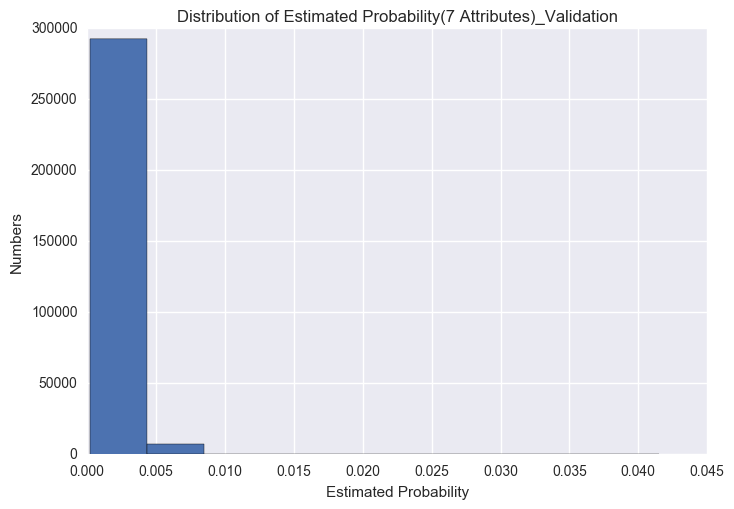

In [105]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
va_df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(7 Attributes)_Validation")
plt.legend()
plt.show()

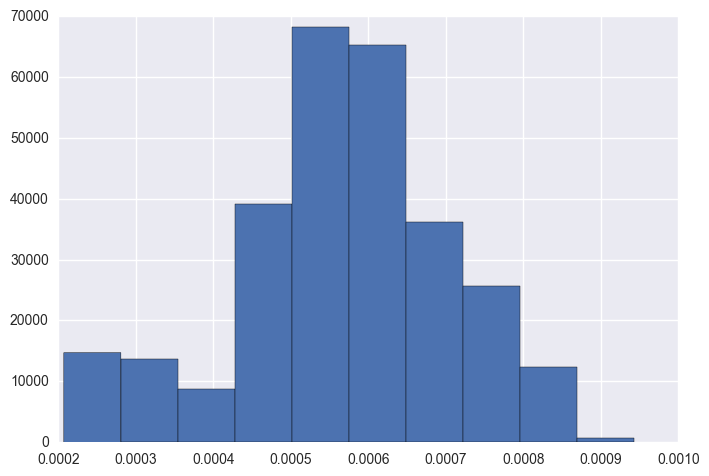

In [106]:
va_df_small = va_df[va_df['log_prob'] < 0.001]
va_df_small['log_prob'].hist()
plt.show()

In [107]:
print(va_df['log_prob'].describe())

count    299745.000000
mean          0.000754
std           0.001081
min           0.000207
25%           0.000500
50%           0.000581
75%           0.000675
max           0.041526
Name: log_prob, dtype: float64


In [108]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


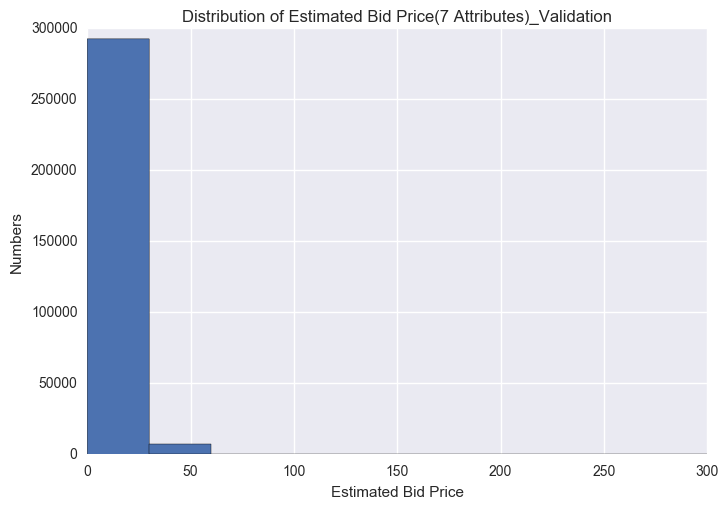

In [109]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation")
plt.legend()
plt.show()

In [110]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean          3.968948
std           7.851911
min           0.000000
25%           2.126791
50%           2.717491
75%           3.396432
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 61.65250733329463
skewness: 15.311555572189686
kurtosis: 401.828155830739


In [111]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


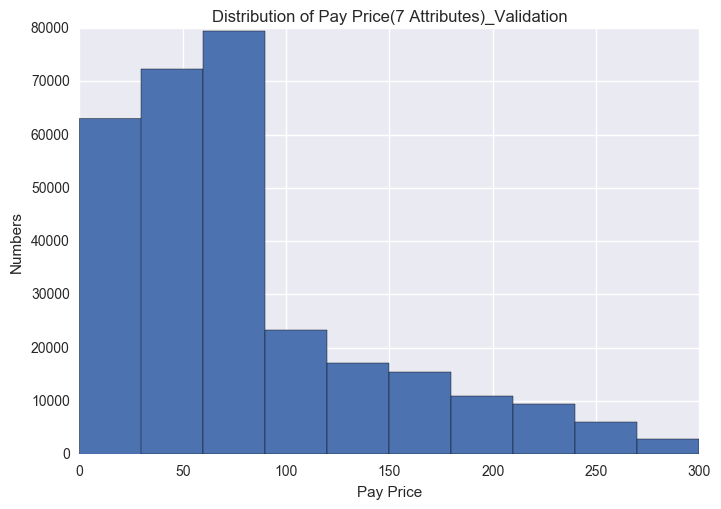

In [112]:
plt.xlabel('Pay Price')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Pay Price(7 Attributes)_Validation")
plt.legend()
plt.show()

In [113]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


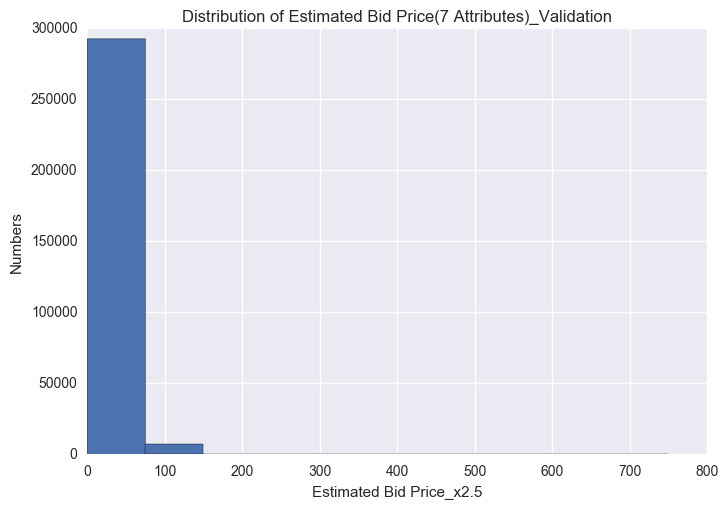

In [114]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation")
plt.legend()
plt.show()

#### Tables

In [115]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

In [116]:
## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

In [117]:
## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

In [118]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

In [119]:
impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

In [120]:
va_df.click.value_counts()
df.payprice.median()

70.0

In [121]:
df_click1 = df[df['click'] ==1]
df.click.value_counts()

0    2695612
1       2034
Name: click, dtype: int64

In [122]:
df_click1.payprice.median()

84.0

In [123]:
va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

In [124]:
impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

In [125]:
va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [126]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |   4245   |  22 | 0.005182567726737338|
|   estimatedBidPrice_x2.5  |  14704   |  30 | 0.002040261153427639|
| estimatedBidPrice_x2.5_d25|  14160   |  30 | 0.00211864406779661 |
| estimatedBidPrice_x2.5_d50|  12045   |  30 |0.0024906600249066002|
|    estimatedBidPrice_x4   |  24538   |  39 |0.0015893715869263999|
|  estimatedBidPrice_linear |  158605  | 115 |0.0007250717190504713|
|estimatedBidPrice_linear_70|  131605  | 101 |0.0007674480452870331|
+---------------------------+----------+-----+---------------------+


In [127]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.7) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d71_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.715) )]
click_d71_5 = impression_d71_5[impression_d71_5['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d71_5", impression_d71_5.shape[0], \
           click_d71_5.shape[0], \
           click_d71_5.shape[0]/impression_d71_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
| estimatedBidPrice_x2.5_d65 |  10382   |  30 |0.0028896166441918707|
| estimatedBidPrice_x2.5_d70 |   9949   |  30 | 0.003015378429992964|
|estimatedBidPrice_x2.5_d71_5|   9805   |  30 |0.0030596634370219276|
| estimatedBidPrice_x2.5_d75 |   9485   |  30 |0.0031628887717448603|
+----------------------------+----------+-----+---------------------+


In [128]:
log_prob_list = va_df['log_prob'].tolist()
va_df.log_prob.describe()
for i in range(len(log_prob_list)):
    if log_prob_list[i] > 0.000637:
    # if log_prob_list[i] > va_df.log_prob.quantile(0.75): 
        log_prob_list[i] *= 5
    elif 0.000637> log_prob_list[i] > 0.000593  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.5):
        log_prob_list[i] *=4.1
        
    elif 0.000593> log_prob_list[i] > 0.000551  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.25):
        log_prob_list[i] *=0.1
        
    elif 0.000551> log_prob_list[i] > 0.000437  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0):
        log_prob_list[i] *=0.01 
        
va_df['estimatedBidPrice_linear2'] = pd.DataFrame(log_prob_list) * 84 / 2034 * 2697738
impression_linear2 = va_df[(va_df['estimatedBidPrice_linear2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.15) )]
click_linear2 = impression_linear2[impression_linear2['click'] == 1 ]        
               
z = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
z.align["Impression"] = "1" # Left align city names 
z.padding_width = 0 # One space between column edges and contents (default)

z.add_row(["estimatedBidPrice_linear2", impression_linear2.shape[0], \
           click_linear2.shape[0], \
           click_linear2.shape[0]/impression_linear2.shape[0]])

print(z)

+-------------------------+----------+-----+---------------------+
|         Variable        |Impression|Click|         CTR         |
+-------------------------+----------+-----+---------------------+
|estimatedBidPrice_linear2|  127150  |  99 |0.0007786079433739678|
+-------------------------+----------+-----+---------------------+


In [129]:
pd.DataFrame(narray).to_csv('narray.csv', encoding='utf-8')
pd.DataFrame(probarray).to_csv('probarray.csv', encoding='utf-8')

## Training Logistic Regression (linear_model.LogisticRegressionCV)

In [130]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [131]:
# Training the model
logregCV = linear_model.LogisticRegressionCV()

In [132]:
logregCV.fit(X, Y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [133]:
logregCV.score(X_validation, Y_validation)

0.99924602578858701

In [134]:
logregCV.predict_proba(X_validation)

array([[  9.99246218e-01,   7.53782330e-04],
       [  9.99153862e-01,   8.46138129e-04],
       [  9.99269515e-01,   7.30484679e-04],
       ..., 
       [  9.99230068e-01,   7.69931699e-04],
       [  9.99258955e-01,   7.41045474e-04],
       [  9.99229798e-01,   7.70202245e-04]])

In [135]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70', 'estimatedBidPrice_linear2'], axis=1, inplace=True)

In [136]:
va_df.head()

,click,weekday,hour,city,payprice,bidprice,slotsize,0,1,5,...,3358,3386,3427,3476,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,226,102,227,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,3,1,211,118,277,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,1,148,77,241,2,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,5,2,147,77,241,2,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,5,1,250,178,300,2,1,0,0,...,0,1,0,0,1,0,0,0,0,0


In [220]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70'], axis=1, inplace=True)

In [221]:
va_df.columns

Index([        'click',       'weekday',          'hour',          'city',
            'payprice',      'bidprice',      'slotsize',             '0',
                   '1',             '5',            'Na',            1458,
                  2259,            2261,            2821,            2997,
                  3358,            3386,            3427,            3476,
       'agent_windows', 'agent_android',     'agent_mac',   'agent_linux',
           'agent_ios',   'agent_other'],
      dtype='object')

In [222]:
probarray = logregCV.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99246218e-01,   7.53782330e-04],
       [  9.99153862e-01,   8.46138129e-04],
       [  9.99269515e-01,   7.30484679e-04],
       ..., 
       [  9.99230068e-01,   7.69931699e-04],
       [  9.99258955e-01,   7.41045474e-04],
       [  9.99229798e-01,   7.70202245e-04]])

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


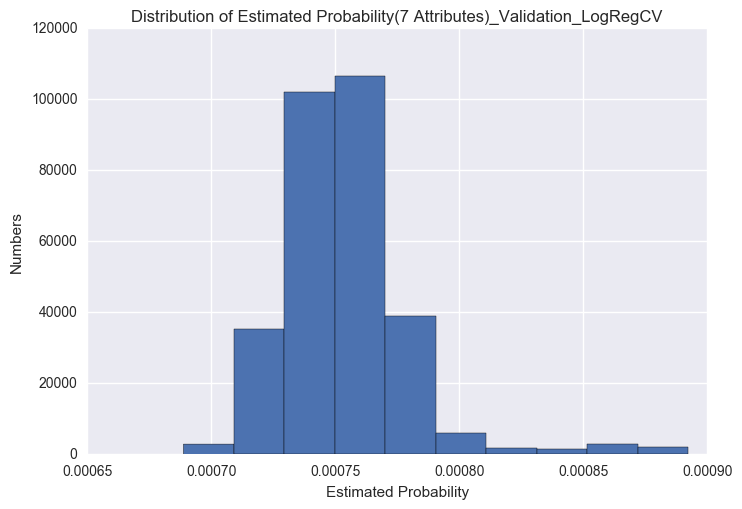

In [223]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
va_df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(7 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

count    299745.000000
mean          0.000754
std           0.000025
min           0.000689
25%           0.000738
50%           0.000752
75%           0.000765
max           0.000892
Name: log_prob, dtype: float64


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


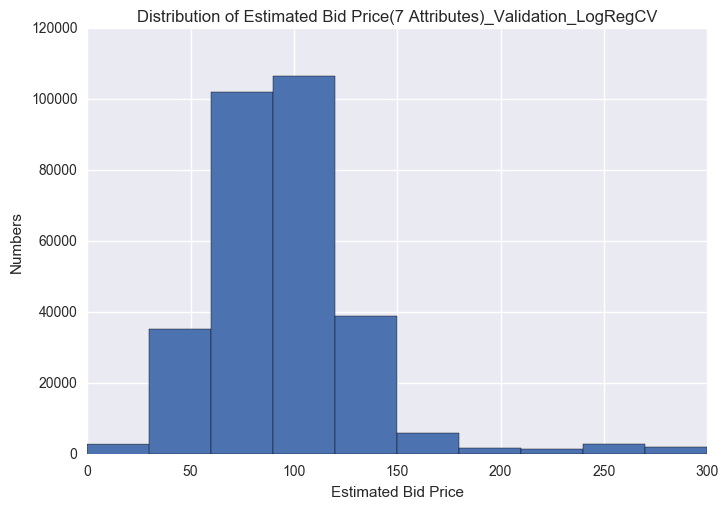

In [224]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

In [225]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean         95.797284
std          37.507707
min           0.000000
25%          73.048777
50%          92.438496
75%         112.074065
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 1406.828114952515
skewness: 1.7896469936757007
kurtosis: 6.444920869524829


In [226]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


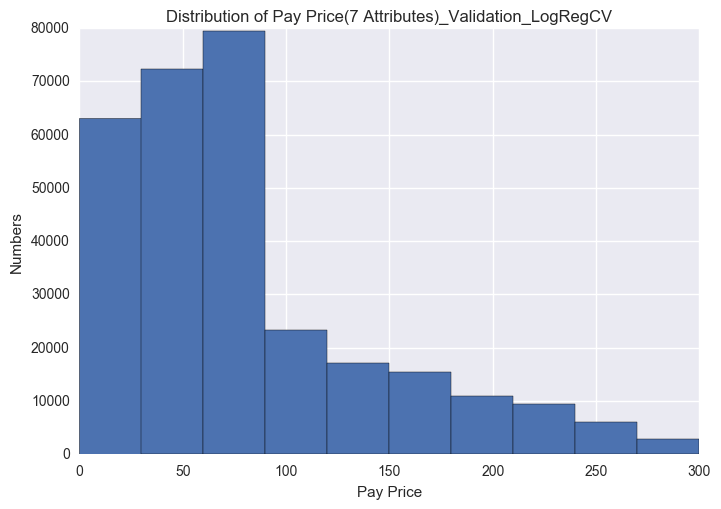

In [227]:
plt.xlabel('Pay Price')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Pay Price(7 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

In [143]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


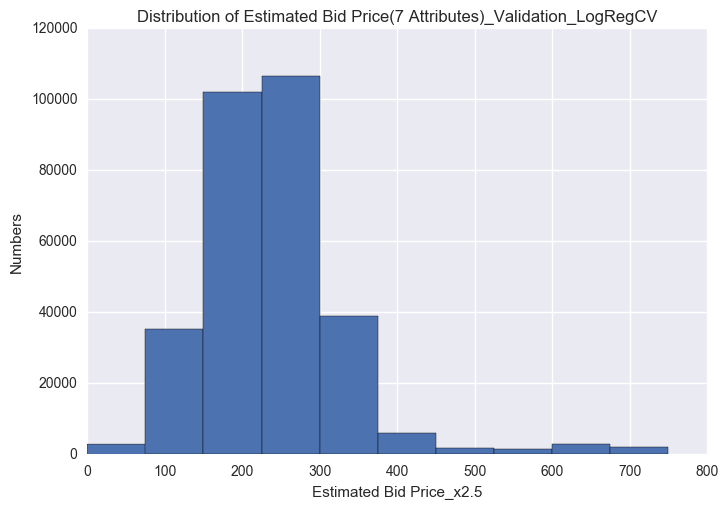

In [144]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

### Tables

In [145]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [146]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  194353  | 126 |0.0006483048885275761|
|   estimatedBidPrice_x2.5  |  284652  | 213 |0.0007482821128957464|
| estimatedBidPrice_x2.5_d25|  218799  | 173 |0.0007906800305303041|
| estimatedBidPrice_x2.5_d50|  148237  | 133 |0.0008972118971646755|
|    estimatedBidPrice_x4   |  297524  | 225 |0.0007562415132896842|
|  estimatedBidPrice_linear |  200873  | 109 |0.0005426314138784207|
|estimatedBidPrice_linear_70|  154155  |  64 |0.0004151665531445623|
+---------------------------+----------+-----+---------------------+


In [147]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.7) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d71_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.715) )]
click_d71_5 = impression_d71_5[impression_d71_5['click'] == 1 ]

impression_d72 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.72) )]
click_d72 = impression_d72[impression_d72['click'] == 1 ]

impression_d72_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.725) )]
click_d72_5 = impression_d72_5[impression_d72_5['click'] == 1 ]

impression_d73 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.73) )]
click_d73 = impression_d73[impression_d73['click'] == 1 ]

impression_d73_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.735) )]
click_d73_5 = impression_d73_5[impression_d73_5['click'] == 1 ]

impression_d74 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.74) )]
click_d74 = impression_d74[impression_d74['click'] == 1 ]

impression_d74_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.745) )]
click_d74_5 = impression_d74_5[impression_d74_5['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d71_5", impression_d71_5.shape[0], \
           click_d71_5.shape[0], \
           click_d71_5.shape[0]/impression_d71_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d72", impression_d72.shape[0], \
           click_d72.shape[0], \
           click_d72.shape[0]/impression_d72.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d72_5", impression_d72_5.shape[0], \
           click_d72_5.shape[0], \
           click_d72_5.shape[0]/impression_d72_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d73", impression_d73.shape[0], \
           click_d73.shape[0], \
           click_d73.shape[0]/impression_d73.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d73_5", impression_d73_5.shape[0], \
           click_d73_5.shape[0], \
           click_d73_5.shape[0]/impression_d73_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d74", impression_d74.shape[0], \
           click_d74.shape[0], \
           click_d74.shape[0]/impression_d74.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d74_5", impression_d74_5.shape[0], \
           click_d74_5.shape[0], \
           click_d74_5.shape[0]/impression_d74_5.shape[0]])


y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
| estimatedBidPrice_x2.5_d65 |  104474  | 116 |0.0011103240997760208|
| estimatedBidPrice_x2.5_d70 |  89664   | 107 | 0.001193344039971449|
|estimatedBidPrice_x2.5_d71_5|  85244   | 102 |0.0011965651541457464|
| estimatedBidPrice_x2.5_d72 |  83768   | 101 |0.0012057110113647216|
|estimatedBidPrice_x2.5_d72_5|  82292   | 101 |0.0012273368006610606|
| estimatedBidPrice_x2.5_d73 |  80809   | 101 |0.0012498607828335952|
|estimatedBidPrice_x2.5_d73_5|  79317   | 101 |0.0012733714083992083|
| estimatedBidPrice_x2.5_d74 |  77829   |  98 |0.0012591707461229104|
|estimatedBidPrice_x2.5_d74_5|  76345   |  98 |0.0012836466042307944|
| estimatedBidPrice_x2.5_d75 |  74856   |  97 |0.0012958213102490113|
+----------------------------+----------+-----+---------------------+


In [148]:
impression1 = impression_d70
impression2 = impression_d71_5
impression3 = impression_d72
impression4 = impression_d72_5
impression5 = impression_d73
impression6 = impression_d73_5
impression7 = impression_d74
impression8 = impression_d74_5
impression9 = impression_d75

In [150]:
click8 = impression8[impression8['click'] == 1 ]
cost8 = impression8['payprice'].sum()/1000

In [151]:
a = PrettyTable(["Variable", "Number"])
a.align["Number"] = "1" # Left align  
a.padding_width = 0 # One space between column edges and contents (default)

a.add_row(["Cost", cost8])

                 
a.add_row(["Impression", impression8.shape[0]])
                 
                 
a.add_row(["Click", click8.shape[0]])          
                 
                 
a.add_row(["CTR", click8.shape[0]/impression8.shape[0]])                 
          
               
# avg CPM = cost per thousand impressions
a.add_row(["avg CPM", cost8  /  ( impression8.shape[0] / 1000) ])
                 
                 
# avg CPC = cost per click
a.add_row(["avg CPC", cost8/click8.shape[0]])

print(a)

+----------+---------------------+
| Variable |        Number       |
+----------+---------------------+
|   Cost   |       6551.856      |
|Impression|        76345        |
|  Click   |          98         |
|   CTR    |0.0012836466042307944|
| avg CPM  |  85.81905822254241  |
| avg CPC  |  66.85567346938775  |
+----------+---------------------+


In [163]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.2'] = va_df['log_prob'].apply(  lambda x: f(x)*2.2 )

In [164]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.7) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d71_5 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.715) )]
click_d71_5 = impression_d71_5[impression_d71_5['click'] == 1 ]

impression_d72 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.72) )]
click_d72 = impression_d72[impression_d72['click'] == 1 ]

impression_d72_5 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.725) )]
click_d72_5 = impression_d72_5[impression_d72_5['click'] == 1 ]

impression_d73 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.73) )]
click_d73 = impression_d73[impression_d73['click'] == 1 ]

impression_d73_5 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.735) )]
click_d73_5 = impression_d73_5[impression_d73_5['click'] == 1 ]

impression_d74 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.74) )]
click_d74 = impression_d74[impression_d74['click'] == 1 ]

impression_d74_5 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.745) )]
click_d74_5 = impression_d74_5[impression_d74_5['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

impression_d80 = va_df[(va_df['estimatedBidPrice_x2.2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.8) )]
click_d80 = impression_d80[impression_d80['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.2_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d71_5", impression_d71_5.shape[0], \
           click_d71_5.shape[0], \
           click_d71_5.shape[0]/impression_d71_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d72", impression_d72.shape[0], \
           click_d72.shape[0], \
           click_d72.shape[0]/impression_d72.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d72_5", impression_d72_5.shape[0], \
           click_d72_5.shape[0], \
           click_d72_5.shape[0]/impression_d72_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d73", impression_d73.shape[0], \
           click_d73.shape[0], \
           click_d73.shape[0]/impression_d73.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d73_5", impression_d73_5.shape[0], \
           click_d73_5.shape[0], \
           click_d73_5.shape[0]/impression_d73_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d74", impression_d74.shape[0], \
           click_d74.shape[0], \
           click_d74.shape[0]/impression_d74.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d74_5", impression_d74_5.shape[0], \
           click_d74_5.shape[0], \
           click_d74_5.shape[0]/impression_d74_5.shape[0]])


y.add_row(["estimatedBidPrice_x2.2_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

y.add_row(["estimatedBidPrice_x2.2_d80", impression_d80.shape[0], \
           click_d80.shape[0], \
           click_d80.shape[0]/impression_d80.shape[0]])

print(y)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
| estimatedBidPrice_x2.2_d65 |  103044  | 114 |0.0011063235122860137|
| estimatedBidPrice_x2.2_d70 |  88652   | 105 | 0.001184406443171051|
|estimatedBidPrice_x2.2_d71_5|  84351   | 100 |0.0011855224004457565|
| estimatedBidPrice_x2.2_d72 |  82898   |  99 |0.0011942387029843906|
|estimatedBidPrice_x2.2_d72_5|  81457   |  99 | 0.001215365161987306|
| estimatedBidPrice_x2.2_d73 |  80011   |  99 | 0.001237329867143268|
|estimatedBidPrice_x2.2_d73_5|  78557   |  99 |0.0012602314243161017|
| estimatedBidPrice_x2.2_d74 |  77097   |  96 |0.0012451846375345344|
|estimatedBidPrice_x2.2_d74_5|  75668   |  96 |0.0012687001110112596|
| estimatedBidPrice_x2.2_d75 |  74213   |  95 |0.0012800991739991645|
| estimatedBidPrice_x2.2_d80 |  59596   |  88 |0.0014766091684005637|
+-------------------

In [165]:
impression1 = impression_d70
impression2 = impression_d71_5
impression3 = impression_d72
impression4 = impression_d72_5
impression5 = impression_d73
impression6 = impression_d73_5
impression7 = impression_d74
impression8 = impression_d74_5
impression9 = impression_d75
impression10 = impression_d80

In [166]:
impression8 = impression_d75

In [167]:
click8 = impression8[impression8['click'] == 1 ]
cost8 = impression8['payprice'].sum()/1000
cost8

6248.96

In [168]:
a = PrettyTable(["Variable", "Number"])
a.align["Number"] = "1" # Left align  
a.padding_width = 0 # One space between column edges and contents (default)

a.add_row(["Cost", cost8])

                 
a.add_row(["Impression", impression8.shape[0]])
                 
                 
a.add_row(["Click", click8.shape[0]])          
                 
                 
a.add_row(["CTR", click8.shape[0]/impression8.shape[0]])                 
          
               
# avg CPM = cost per thousand impressions
a.add_row(["avg CPM", cost8  /  ( impression8.shape[0] / 1000) ])
                 
                 
# avg CPC = cost per click
a.add_row(["avg CPC", cost8/click8.shape[0]])

print(a)

+----------+---------------------+
| Variable |        Number       |
+----------+---------------------+
|   Cost   |       6248.96       |
|Impression|        74213        |
|  Click   |          95         |
|   CTR    |0.0012800991739991645|
| avg CPM  |  84.20303720372442  |
| avg CPC  |  65.77852631578948  |
+----------+---------------------+


In [170]:
va_df.drop('estimatedBidPrice_x2.2', axis = 1, inplace = True)

In [171]:
va_df['log_prob'].describe()

count    299745.000000
mean          0.000754
std           0.000025
min           0.000689
25%           0.000738
50%           0.000752
75%           0.000765
max           0.000892
Name: log_prob, dtype: float64

In [172]:
log_prob_list = va_df['log_prob'].tolist()
va_df.log_prob.describe()
for i in range(len(log_prob_list)):
    if log_prob_list[i] > 0.000765:
    # if log_prob_list[i] > va_df.log_prob.quantile(0.75): 
        log_prob_list[i] *= 0.1
    elif 0.000765> log_prob_list[i] > 0.000752  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.5):
        log_prob_list[i] *= 0.2
        
    elif 0.000752> log_prob_list[i] > 0.000738  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.25):
        log_prob_list[i] *= 3
        
    elif 0.000738> log_prob_list[i] > 0.000688  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0):
        log_prob_list[i] *= 3.5   
        
va_df['estimatedBidPrice_linear2'] = pd.DataFrame(log_prob_list) * 84 / 2034 * 2697738
impression_linear2 = va_df[(va_df['estimatedBidPrice_linear2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.40) )]
click_linear2 = impression_linear2[impression_linear2['click'] == 1 ]        
               
z = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
z.align["Impression"] = "1" # Left align city names 
z.padding_width = 0 # One space between column edges and contents (default)

z.add_row(["estimatedBidPrice_linear2", impression_linear2.shape[0], \
           click_linear2.shape[0], \
           click_linear2.shape[0]/impression_linear2.shape[0]])

print(z)

+-------------------------+----------+-----+---------------------+
|         Variable        |Impression|Click|         CTR         |
+-------------------------+----------+-----+---------------------+
|estimatedBidPrice_linear2|  95960   |  79 |0.0008232596915381409|
+-------------------------+----------+-----+---------------------+


## Training Logistic Regression (linear_model.SGDClassifier(loss='log'))

In [173]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [174]:
# Training the model
SGDlog = linear_model.SGDClassifier(loss='log')

In [175]:
SGDlog.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [176]:
SGDlog.score(X_validation, Y_validation)

0.99924602578858701

In [177]:
SGDlog.predict_proba(X_validation)

array([[  9.99998104e-01,   1.89624994e-06],
       [  9.99984715e-01,   1.52849225e-05],
       [  9.99992679e-01,   7.32113577e-06],
       ..., 
       [  9.99828153e-01,   1.71847145e-04],
       [  9.99999181e-01,   8.19069497e-07],
       [  9.99949309e-01,   5.06907949e-05]])

In [178]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70', 'estimatedBidPrice_linear2'], axis=1, inplace=True)

In [185]:
va_df.columns

Index([        'click',       'weekday',          'hour',          'city',
            'payprice',      'bidprice',      'slotsize',             '0',
                   '1',             '5',            'Na',            1458,
                  2259,            2261,            2821,            2997,
                  3358,            3386,            3427,            3476,
       'agent_windows', 'agent_android',     'agent_mac',   'agent_linux',
           'agent_ios',   'agent_other'],
      dtype='object')

In [186]:
probarray = SGDlog.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99998104e-01,   1.89624994e-06],
       [  9.99984715e-01,   1.52849225e-05],
       [  9.99992679e-01,   7.32113577e-06],
       ..., 
       [  9.99828153e-01,   1.71847145e-04],
       [  9.99999181e-01,   8.19069497e-07],
       [  9.99949309e-01,   5.06907949e-05]])

count    2.997450e+05
mean     1.606949e-04
std      5.268891e-04
min      5.549036e-09
25%      1.494000e-06
50%      1.272409e-05
75%      1.067395e-04
max      1.155859e-02
Name: log_prob, dtype: float64


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


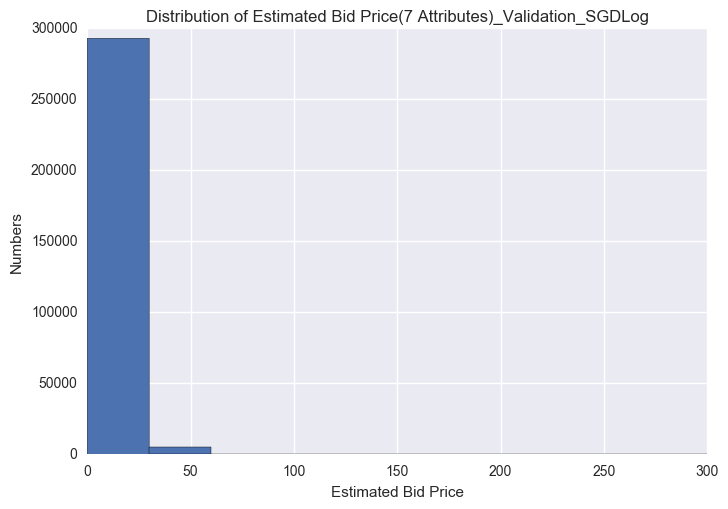

In [187]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [188]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean          4.170649
std          13.675268
min           0.000000
25%           0.038632
50%           0.330107
75%           2.770251
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 187.01295773628317
skewness: 11.042207509960223
kurtosis: 170.1118925306233


In [189]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


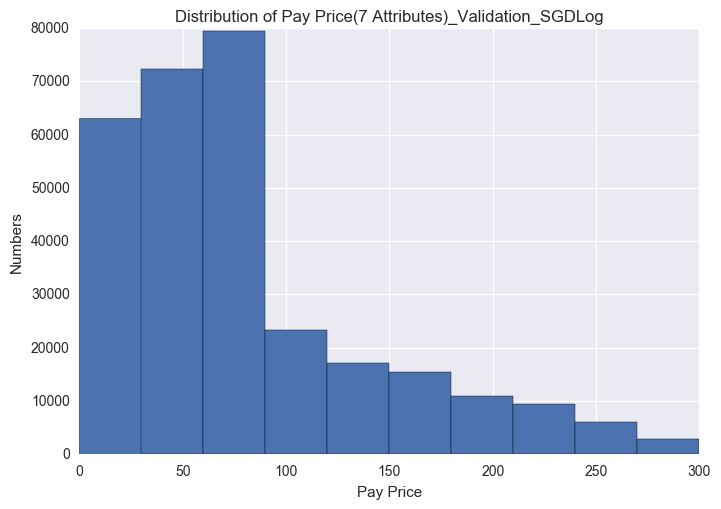

In [190]:
plt.xlabel('Pay Price')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Pay Price(7 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [191]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


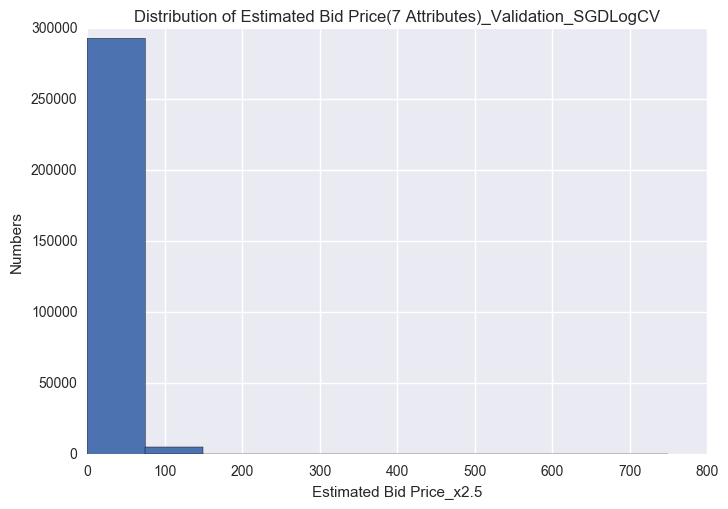

In [192]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_SGDLogCV")
plt.legend()
plt.show()

### Table

In [193]:
impression = va_df[(va_df['estimatedBidPrice'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0) )]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [194]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |   6077   |  9  | 0.001480993911469475|
|   estimatedBidPrice_x2.5  |  17331   |  12 |0.0006924009001211701|
| estimatedBidPrice_x2.5_d25|  17321   |  12 |0.0006928006466139368|
| estimatedBidPrice_x2.5_d50|  17302   |  12 |0.0006935614379840481|
|    estimatedBidPrice_x4   |  27477   |  19 |0.0006914874258470721|
|  estimatedBidPrice_linear |  29139   |  20 |0.0006863653522770171|
|estimatedBidPrice_linear_70|  24910   |  18 |0.0007226013649136892|
+---------------------------+----------+-----+---------------------+


In [195]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.70) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+--------------------------+----------+-----+---------------------+
|         Variable         |Impression|Click|         CTR         |
+--------------------------+----------+-----+---------------------+
|estimatedBidPrice_x2.5_d65|  17246   |  12 |0.0006958135219761104|
|estimatedBidPrice_x2.5_d70|  17180   |  12 |0.0006984866123399302|
|estimatedBidPrice_x2.5_d75|  16837   |  12 |0.0007127160420502465|
+--------------------------+----------+-----+---------------------+


In [196]:
log_prob_list = va_df['log_prob'].tolist()
va_df.log_prob.describe()
for i in range(len(log_prob_list)):
    if log_prob_list[i] > 0.000765:
    # if log_prob_list[i] > va_df.log_prob.quantile(0.75): 
        log_prob_list[i] *= 3.5
    elif 0.000765> log_prob_list[i] > 0.000752  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.5):
        log_prob_list[i] *=3
        
    elif 0.000752> log_prob_list[i] > 0.000740  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.25):
        log_prob_list[i] *=0.2
        
    elif 0.000740> log_prob_list[i] > 0.000695  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0):
        log_prob_list[i] *=0.1   
        
va_df['estimatedBidPrice_linear2'] = pd.DataFrame(log_prob_list) * 84 / 2034 * 2697738
impression_linear2 = va_df[(va_df['estimatedBidPrice_linear2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.40) )]
click_linear2 = impression_linear2[impression_linear2['click'] == 1 ]        
               
z = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
z.align["Impression"] = "1" # Left align city names 
z.padding_width = 0 # One space between column edges and contents (default)

z.add_row(["estimatedBidPrice_linear2", impression_linear2.shape[0], \
           click_linear2.shape[0], \
           click_linear2.shape[0]/impression_linear2.shape[0]])

print(z)

+-------------------------+----------+-----+--------------------+
|         Variable        |Impression|Click|        CTR         |
+-------------------------+----------+-----+--------------------+
|estimatedBidPrice_linear2|  18449   |  13 |0.000704645238224294|
+-------------------------+----------+-----+--------------------+


## Lasso

In [197]:
clf = linear_model.Lasso(alpha = 0.1)

In [198]:
clf.fit(X, Y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [199]:
clf.score(X_validation, Y_validation)

-3.6060043839825084e-13

In [200]:
clf.predict(X_validation)

array([ 0.00075399,  0.00075399,  0.00075399, ...,  0.00075399,
        0.00075399,  0.00075399])

## Ridge 

In [201]:
ridge = linear_model.Ridge(alpha = 1.0)

In [202]:
ridge.fit(X,Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [203]:
ridge.score(X_validation, Y_validation)

0.0014468303642242164

In [204]:
ridge.predict(X_validation)

array([ 0.00052115,  0.00457945,  0.00066631, ...,  0.00060248,
        0.00049586,  0.00074872])

In [205]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70', 'estimatedBidPrice_linear2'], axis=1, inplace=True)

In [206]:
X_va = va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]]

In [207]:
probarray = ridge.predict(X_va)
va_df['log_prob'] =probarray
probarray

array([ 0.00052115,  0.00457945,  0.00066631, ...,  0.00060248,
        0.00049586,  0.00074872])

count    299745.000000
mean          0.000750
std           0.000930
min           0.000032
25%           0.000472
50%           0.000574
75%           0.000683
max           0.012562
Name: log_prob, dtype: float64


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


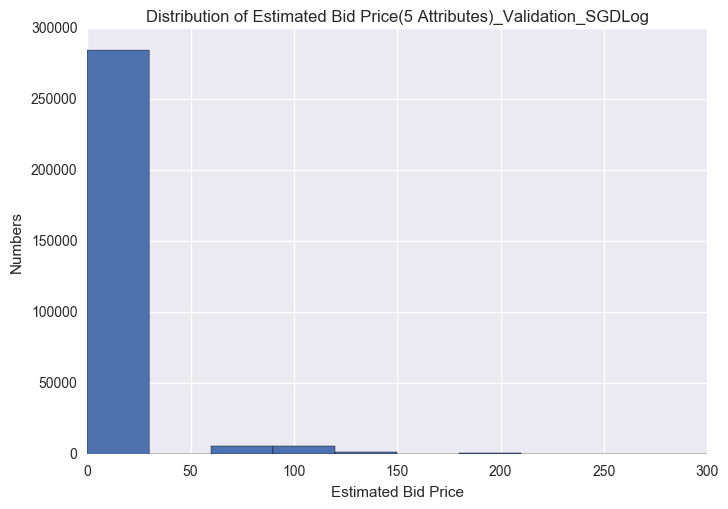

In [208]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [209]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean         17.191980
std          22.260850
min           0.000000
25%          10.538566
50%          12.970135
75%          15.583875
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 495.54543878120586
skewness: 5.1238626371894025
kurtosis: 31.162783412181142


In [210]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


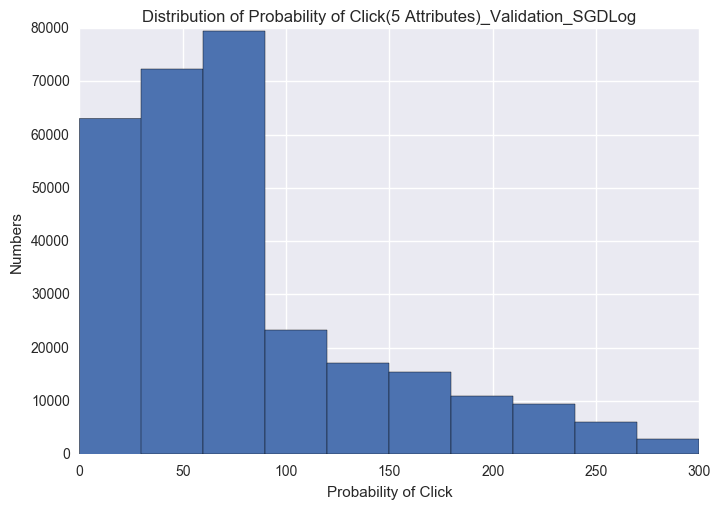

In [211]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(5 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [212]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


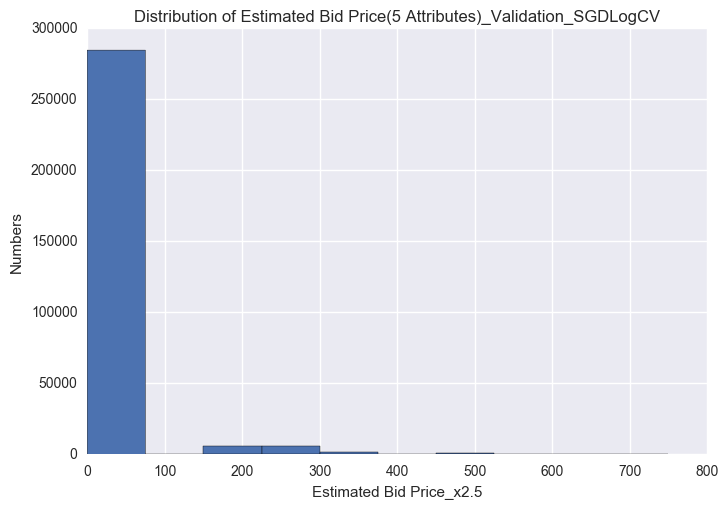

In [213]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_SGDLogCV")
plt.legend()
plt.show()

### Tables

In [214]:
impression = va_df[(va_df['estimatedBidPrice'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0) )]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [215]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  28179   |  36 |0.0012775471095496647|
|   estimatedBidPrice_x2.5  |  76066   |  73 |0.0009596928982725527|
| estimatedBidPrice_x2.5_d25|  66730   |  71 |0.0010639892102502623|
| estimatedBidPrice_x2.5_d50|  50972   |  70 |0.0013733029898767952|
|    estimatedBidPrice_x4   |  125134  |  99 | 0.000791151885179088|
|  estimatedBidPrice_linear |  155779  | 119 |0.0007639027083239717|
|estimatedBidPrice_linear_70|  128973  | 100 |0.0007753560822807875|
+---------------------------+----------+-----+---------------------+
